In [1]:
import logging
import math
import os
import sys

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from ipywidgets import IntProgress
from keras.layers import LSTM, Conv1D, Dense, Dropout,BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam

"Need for predicting a music genre from a custom audio file"
import IPython.display as ipd
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from datetime import datetime 
import re

In [2]:

class MusicFeatureExtractor:

    "Music audio features for genre classification"
    hop_length = None
    genre_list = [
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
    ]

    dir_trainfolder = "./Data/gtzan/_train"
    dir_devfolder = "./Data/gtzan/_validation"
    dir_testfolder = "./Data/gtzan/_test"
    dir_all_files = "./Data/gtzan"

    train_X_preprocessed_data = "./Data/gtzan/data_train_input.npy"
    train_Y_preprocessed_data = "./Data/gtzan/data_train_target.npy"
    dev_X_preprocessed_data = "./Data/gtzan/data_validation_input.npy"
    dev_Y_preprocessed_data = "./Data/gtzan/data_validation_target.npy"
    test_X_preprocessed_data = "./Data/gtzan/data_test_input.npy"
    test_Y_preprocessed_data = "./Data/gtzan/data_test_target.npy"

    train_X = train_Y = None
    dev_X = dev_Y = None
    test_X = test_Y = None

    def __init__(self):
        self.hop_length = 512

        self.timeseries_length_list = []
        self.trainfiles_list = self.path_to_audiofiles(self.dir_trainfolder)
        self.devfiles_list = self.path_to_audiofiles(self.dir_devfolder)
        self.testfiles_list = self.path_to_audiofiles(self.dir_testfolder)

        self.all_files_list = []
        self.all_files_list.extend(self.trainfiles_list)
        self.all_files_list.extend(self.devfiles_list)
        self.all_files_list.extend(self.testfiles_list)

        self.timeseries_length = (
            128
        )   # sequence length == 128, default fftsize == 2048 & hop == 512 @ SR of 22050
        #  equals 128 overlapped windows that cover approx ~3.065 seconds of audio, which is a bit small!

    def load_preprocess_data(self):
        print("[DEBUG] total number of files: " + str(len(self.timeseries_length_list)))

        # Training set
        self.train_X, self.train_Y = self.extract_audio_features(self.trainfiles_list)
        with open(self.train_X_preprocessed_data, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_Y_preprocessed_data, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)

        # Validation set
        self.dev_X, self.dev_Y = self.extract_audio_features(self.devfiles_list)
        with open(self.dev_X_preprocessed_data, "wb") as f:
            np.save(f, self.dev_X)
        with open(self.dev_Y_preprocessed_data, "wb") as f:
            self.dev_Y = self.one_hot(self.dev_Y)
            np.save(f, self.dev_Y)

        # Test set
        self.test_X, self.test_Y = self.extract_audio_features(self.testfiles_list)
        with open(self.test_X_preprocessed_data, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_Y_preprocessed_data, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def load_deserialize_data(self):

        self.train_X = np.load(self.train_X_preprocessed_data)
        self.train_Y = np.load(self.train_Y_preprocessed_data)

        self.dev_X = np.load(self.dev_X_preprocessed_data)
        self.dev_Y = np.load(self.dev_Y_preprocessed_data)

        self.test_X = np.load(self.test_X_preprocessed_data)
        self.test_Y = np.load(self.test_Y_preprocessed_data)

    def precompute_min_timeseries_len(self):
        for file in self.all_files_list:
            print("Loading " + str(file))
            y, sr = librosa.load(file)
            self.timeseries_length_list.append(math.ceil(len(y) / self.hop_length))

    def extract_audio_features(self, list_of_audiofiles):

        data = np.zeros(
            (len(list_of_audiofiles), self.timeseries_length, 33), dtype=np.float64
        )
        target = []

        for i, file in enumerate(list_of_audiofiles):
            y, sr = librosa.load(file)
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13
            )
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=self.hop_length
            )
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=self.hop_length
            )

            splits = re.split("[ .]", file)
            genre = re.split("[ /]", splits[1])[4]
            target.append(genre)

            data[i, :, 0:13] = mfcc.T[0:self.timeseries_length, :]
            data[i, :, 13:14] = spectral_center.T[0:self.timeseries_length, :]
            data[i, :, 14:26] = chroma.T[0:self.timeseries_length, :]
            data[i, :, 26:33] = spectral_contrast.T[0:self.timeseries_length, :]

            print(
                "Extracted features audio track %i of %i."
                % (i + 1, len(list_of_audiofiles))
            )

        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot

    @staticmethod
    def path_to_audiofiles(dir_folder):
        list_of_audio = []
        for file in os.listdir(dir_folder):
            if file.endswith(".au"):
                directory = "%s/%s" % (dir_folder, file)
                list_of_audio.append(directory)
        return list_of_audio

In [3]:

# set logging level
logging.getLogger("tensorflow").setLevel(logging.ERROR)

genre_features = MusicFeatureExtractor()

Track file is ./Data/gtzan/_train/hiphop.00077.au
The Genre it belongs is hiphop
./Data/gtzan/_train/hiphop.00077.au
STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


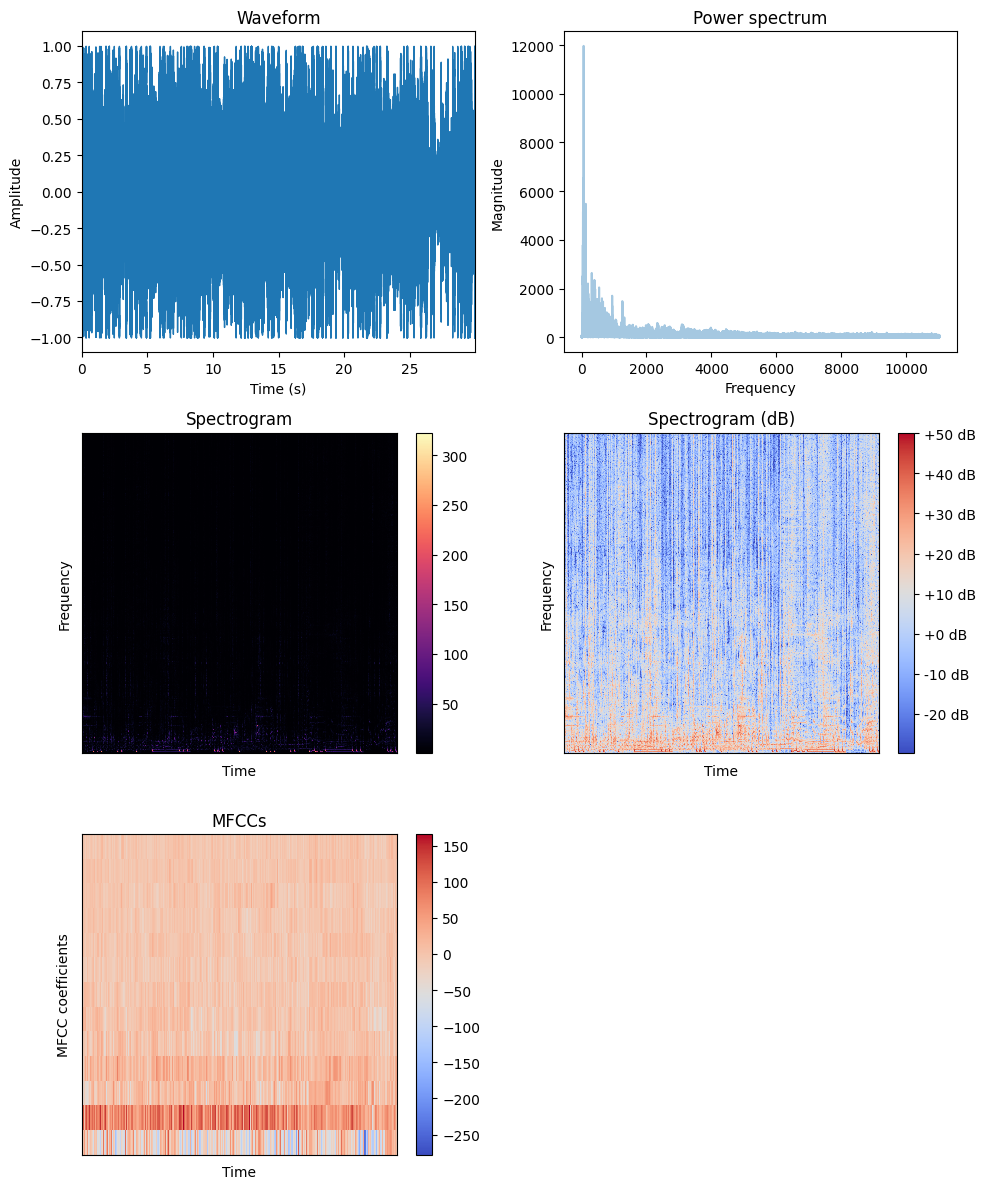

Track file is ./Data/gtzan/_train/pop.00082.au
The Genre it belongs is pop
./Data/gtzan/_train/pop.00082.au
STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


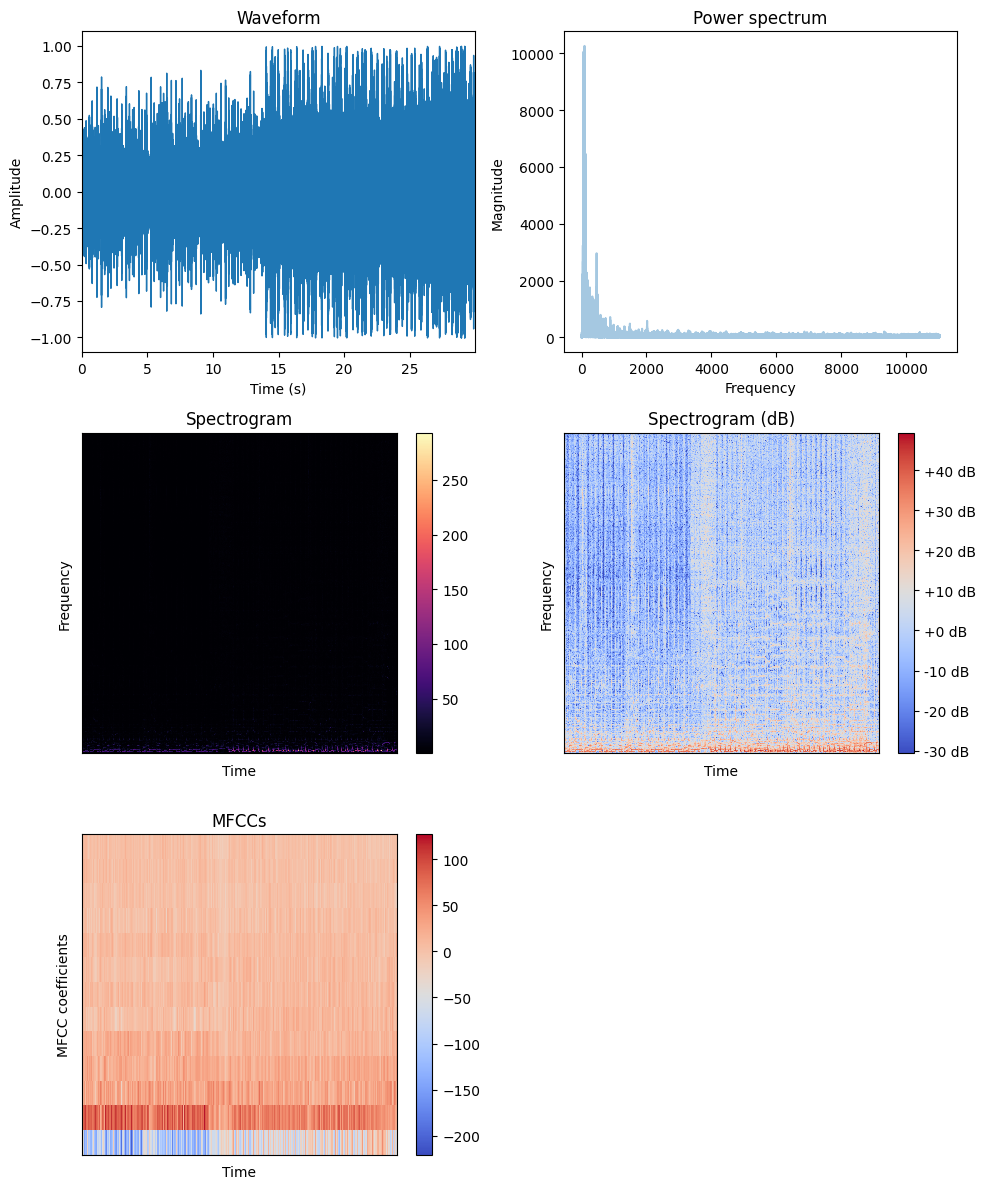

In [4]:
class GraphGenerator:
    def generategraph(self, file, FIG_SIZE=(10, 12)):
        # load audio file with Librosa
        signal, sample_rate = librosa.load(file, sr=22050)
        # fig, ax = plt.subplots(3,2)

        # WAVEFORM
        # display waveform
        fig = plt.figure(figsize=FIG_SIZE)
        plt.subplot(3, 2, 1)
        librosa.display.waveplot(signal, sr=sample_rate)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title("Waveform")

        # FFT -> power spectrum
        # perform Fourier transform
        fft = np.fft.fft(signal)

        # calculate abs values on complex numbers to get magnitude
        spectrum = np.abs(fft)

        # create frequency variable
        f = np.linspace(0, sample_rate, len(spectrum))

        # take half of the spectrum and frequency
        left_spectrum = spectrum[: int(len(spectrum) / 2)]
        left_f = f[: int(len(spectrum) / 2)]

        # plot spectrum
        # plt.figure(figsize=FIG_SIZE)
        plt.subplot(3, 2, 2)
        plt.plot(left_f, left_spectrum, alpha=0.4)
        plt.xlabel("Frequency")
        plt.ylabel("Magnitude")
        plt.title("Power spectrum")

        # STFT -> spectrogram
        hop_length = 512  # in num. of samples
        n_fft = 2048  # window in num. of samples

        # calculate duration hop length and window in seconds
        hop_length_duration = float(hop_length) / sample_rate
        n_fft_duration = float(n_fft) / sample_rate

        print("STFT hop length duration is: {}s".format(hop_length_duration))
        print("STFT window duration is: {}s".format(n_fft_duration))

        # perform stft
        stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

        # calculate abs values on complex numbers to get magnitude
        spectrogram = np.abs(stft)

        # display spectrogram
        # plt.figure(figsize=FIG_SIZE)
        plt.subplot(3, 2, 3)
        librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.title("Spectrogram")

        # apply logarithm to cast amplitude to Decibels
        log_spectrogram = librosa.amplitude_to_db(spectrogram)

        # plt.figure(figsize=FIG_SIZE)
        plt.subplot(3, 2, 4)
        librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format="%+2.0f dB")
        plt.title("Spectrogram (dB)")

        # MFCCs
        # extract 13 MFCCs
        MFCCs = librosa.feature.mfcc(
            signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13
        )

        # display MFCCs
        plt.subplot(3, 2, 5)
        librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("MFCC coefficients")
        plt.colorbar()
        plt.title("MFCCs")
        fig.tight_layout()
        # show plots
        plt.show()


import random

tracks = genre_features.trainfiles_list
random.seed(10)
graph_generator = GraphGenerator()
for i in range(0, 2):
    n = random.Random().randint(0, len(tracks))
    file = tracks[n]
    ipd.Audio(file)
    splits = re.split("[ .]", file)
    track_genre = re.split("[ /]", splits[1])[4]
    print("Track file is {}".format(file))
    print("The Genre it belongs is {}".format(track_genre))
    print(file)

    graph_generator.generategraph(file)

In [5]:
splits = re.split("[ .]", "./Data/gtzan/_train/classical.00030.au")
genre = re.split("[ /]", splits[1])[4]
genre,splits

('classical', ['', '/Data/gtzan/_train/classical', '00030', 'au'])

In [6]:
if (
    os.path.isfile(genre_features.train_X_preprocessed_data)
    and os.path.isfile(genre_features.train_Y_preprocessed_data)
    and os.path.isfile(genre_features.dev_X_preprocessed_data)
    and os.path.isfile(genre_features.dev_Y_preprocessed_data)
    and os.path.isfile(genre_features.test_X_preprocessed_data)
    and os.path.isfile(genre_features.test_Y_preprocessed_data)
):
    print("Preprocessed files exist, deserializing npy files")
    genre_features.load_deserialize_data()
else:
    print("Preprocessing raw audio files")
    genre_features.load_preprocess_data()

print("Training X shape: " + str(genre_features.train_X.shape))
print("Training Y shape: " + str(genre_features.train_Y.shape))
print("Dev X shape: " + str(genre_features.dev_X.shape))
print("Dev Y shape: " + str(genre_features.dev_Y.shape))
print("Test X shape: " + str(genre_features.test_X.shape))
print("Test Y shape: " + str(genre_features.test_Y.shape))

Preprocessed files exist, deserializing npy files
Training X shape: (420, 128, 33)
Training Y shape: (420, 8)
Dev X shape: (120, 128, 33)
Dev Y shape: (120, 8)
Test X shape: (60, 128, 33)
Test Y shape: (60, 8)


In [7]:

input_shape = (genre_features.train_X.shape[1], genre_features.train_X.shape[2])
print("Build LSTM RNN model ...")
model = Sequential()
model.add(Conv1D(128, 8, activation="relu", input_shape=input_shape))
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(units=genre_features.train_Y.shape[1], activation="softmax"))

print("Compiling ...")
# Keras optimizer defaults:
# Adam   : lr=0.001, beta_1=0.9,  beta_2=0.999, epsilon=1e-8, decay=0.
# RMSprop: lr=0.001, rho=0.9,                   epsilon=1e-8, decay=0.
# SGD    : lr=0.01,  momentum=0.,                             decay=0.
opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()


Build LSTM RNN model ...
Compiling ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 121, 128)          33920     
                                                                 
 lstm (LSTM)                 (None, 121, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
Total params: 96,008
Trainable params: 96,008
Non-trainable params: 0
_________________________________________________________________


In [8]:
print("Training ...")
batch_size = 35  # num of training examples per minibatch
num_epochs = 400
model.fit(
    genre_features.train_X,
    genre_features.train_Y,
    batch_size=batch_size,
    epochs=num_epochs,
)

Training ...
Epoch 1/400
12/12 [==============================] - 4s 113ms/step - loss: 1.9108 - accuracy: 0.2452
Epoch 2/400
12/12 [==============================] - 2s 169ms/step - loss: 1.7337 - accuracy: 0.2976
Epoch 3/400
12/12 [==============================] - 2s 167ms/step - loss: 1.6359 - accuracy: 0.3262
Epoch 4/400
12/12 [==============================] - 2s 155ms/step - loss: 1.5629 - accuracy: 0.3357
Epoch 5/400
12/12 [==============================] - 2s 151ms/step - loss: 1.5176 - accuracy: 0.3095
Epoch 6/400
12/12 [==============================] - 2s 148ms/step - loss: 1.5191 - accuracy: 0.3381
Epoch 7/400
12/12 [==============================] - 2s 156ms/step - loss: 1.5216 - accuracy: 0.3357
Epoch 8/400
12/12 [==============================] - 2s 154ms/step - loss: 1.4587 - accuracy: 0.3500
Epoch 9/400
12/12 [==============================] - 2s 145ms/step - loss: 1.4410 - accuracy: 0.3976
Epoch 10/400
12/12 [==============================] - 2s 149ms/step - loss: 1.

In [ ]:
plt.plot(model.history.history["accuracy"], label="training accuracy")
plt.plot(model.history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

In [13]:
print("\nValidating ...")
score, accuracy = model.evaluate(
    genre_features.dev_X, genre_features.dev_Y, batch_size=batch_size, verbose=1
)
print("Dev loss:  ", score)
print("Dev accuracy:  ", accuracy)


Validating ...
4/4 [==============================] - 2s 106ms/step - loss: 0.9991 - accuracy: 0.6750
Dev loss:   0.999144434928894
Dev accuracy:   0.675000011920929


In [14]:
print("\nTesting ...")
score, accuracy = model.evaluate(
    genre_features.test_X, genre_features.test_Y, batch_size=batch_size, verbose=1
)
print("Test loss:  ", score)
print("Test accuracy:  ", accuracy)


Testing ...
2/2 [==============================] - 0s 158ms/step - loss: 1.5841 - accuracy: 0.6500
Test loss:   1.5840755701065063
Test accuracy:   0.6499999761581421


In [16]:
# Creates a HDF5 file 'lstm_genre_classifier.h5'
model_filename = "lstm_genre_classifier_lstm.h5"
print("\nSaving model: " + model_filename)
model.save(model_filename)


Saving model: lstm_genre_classifier_lstm.h5


In [21]:
# Creates a json file
print("creating .json file....")
model_json = model.to_json()
f = open("./lstm_genre_classifier_lstm.json","w+")
f.write(model_json)
f.close()

creating .json file....


In [2]:
"An example of predicting a music genre from a custom audio file"
import librosa
import logging
import sys
import numpy as np
from keras.models import model_from_json

In [6]:


def load_model(model_path, weights_path):
    "Load the trained LSTM model from directory for genre classification"
    with open(model_path, "r") as model_file:
        trained_model = model_from_json(model_file.read())
    trained_model.load_weights(weights_path)
    trained_model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return trained_model


def extract_audio_features(file):
    "Extract audio features from an audio file for genre classification"
    timeseries_length = 128
    features = np.zeros((1, timeseries_length, 33), dtype=np.float64)

    y, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
    spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=512)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=512)

    features[0, :, 0:13] = mfcc.T[0:timeseries_length, :]
    features[0, :, 13:14] = spectral_center.T[0:timeseries_length, :]
    features[0, :, 14:26] = chroma.T[0:timeseries_length, :]
    features[0, :, 26:33] = spectral_contrast.T[0:timeseries_length, :]
    return features

def get_genre(model, music_path):
    "Predict genre of music using a trained model"
    prediction = model.predict(extract_audio_features(music_path))
    predict_genre = GenreFeatureData().genre_list[np.argmax(prediction)]
    return predict_genre


In [20]:
import os
PATH = "C:\\Users/A0826873/Bits/DL/Assignment-2/audio/metal_music.mp3"

MODEL = load_model("./lstm_genre_classifier_lstm.json", "./lstm_genre_classifier_lstm.h5")
GENRE = get_genre(MODEL, PATH)
print("Model predict: {}".format(GENRE))


1/1 [==============================] - 0s 408ms/step
Model predict: reggae
